# Canny Edge Detection Step by Step in Python

The Canny edge detector is an edge detection operator that uses a multi-stage algorithm to detect a wide range of edges in images. It was developed by John F. Canny in 1986. Canny also produced a computational theory of edge detection explaining why the technique works. (Wikipedia)
The Canny edge detection algorithm is composed of 5 steps:
1. Noise reduction;
2. Gradient calculation;
3. Non-maximum suppression;
4. Double threshold;
5. Edge Tracking by Hysteresis.

# Importing required Libraries 

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
from scipy import ndimage

%matplotlib inline

# 1. Noise Reduction
Since the mathematics involved behind the scene are mainly based on derivatives (cf. Step 2: Gradient calculation), edge detection results are highly sensitive to image noise.
One way to get rid of the noise on the image, is by applying Gaussian blur to smooth it. To do so, image convolution technique is applied with a Gaussian Kernel (3x3, 5x5, 7x7 etc…). The kernel size depends on the expected blurring effect. Basically, the smallest the kernel, the less visible is the blur. In our example, we will use a 5 by 5 Gaussian kernel.
The equation for a Gaussian filter kernel of size (2k+1)×(2k+1) is given by:

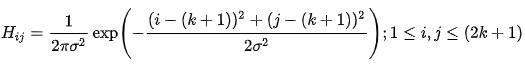

                                            Gaussian filter kernel equation

In [2]:
def gaussian_kernel(size, sigma=1):
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    normal = 1 / (2.0 * np.pi * sigma**2)
    g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
    return g

# 2. Gradient Calculation
The Gradient calculation step detects the edge intensity and direction by calculating the gradient of the image using edge detection operators.
Edges correspond to a change of pixels’ intensity. To detect it, the easiest way is to apply filters that highlight this intensity change in both directions: horizontal (x) and vertical (y)
When the image is smoothed, the derivatives Ix and Iy w.r.t. x and y are calculated. It can be implemented by convolving I with Sobel kernels Kx and Ky, respectively:

Sobel filters for both direction (horizontal and vertical)
Then, the magnitude G and the slope θ of the gradient are calculated as follow:

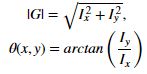

                                    Gradient intensity and Edge direction

In [3]:
def sobel_filters(img):
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)
    
    Ix = ndimage.filters.convolve(img, Kx)
    Iy = ndimage.filters.convolve(img, Ky)
    
    G = np.hypot(Ix, Iy)
    G = G / G.max() * 255
    theta = np.arctan2(Iy, Ix)
    
    return (G, theta)

# 3. Non-Maximum Suppression

Ideally, the final image should have thin edges. Thus, we must perform non-maximum suppression to thin out the edges.

Let’s take an easy example:

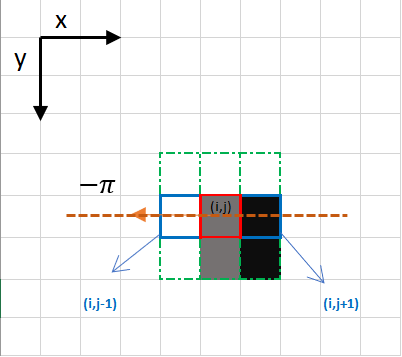

The upper left corner red box present on the above image, represents an intensity pixel of the Gradient Intensity matrix being processed. The corresponding edge direction is represented by the orange arrow with an angle of -pi radians (+/-180 degrees).

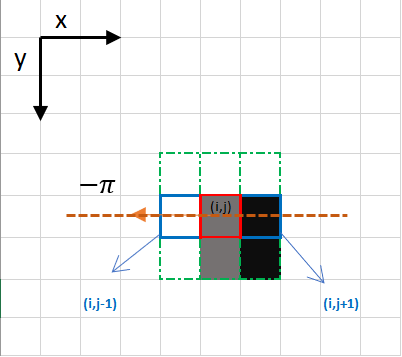

 In the example above, the pixel (i, j) is being processed, and the pixels on the same direction are highlighted in blue (i, j-1) and (i, j+1). If one those two pixels are more intense than the one being processed, then only the more intense one is kept. Pixel (i, j-1) seems to be more intense, because it is white (value of 255). Hence, the intensity value of the current pixel (i, j) is set to 0. If there are no pixels in the edge direction having more intense values, then the value of the current pixel is kept.
 
$ Create a matrix initialized to 0 of the same size of the original gradient intensity matrix;
 
$ Identify the edge direction based on the angle value from the angle matrix;

$ Check if the pixel in the same direction has a higher intensity than the pixel that is currently processed;

$ Return the image processed with the non-max suppression algorithm.

In [4]:
def non_max_suppression(img, D):
    M, N = img.shape
    Z = np.zeros((M,N), dtype=np.int32)
    angle = D * 180. / np.pi
    angle[angle < 0] += 180

    
    for i in range(1,M-1):
        for j in range(1,N-1):
            try:
                q = 255
                r = 255
                
               #angle 0
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = img[i, j+1]
                    r = img[i, j-1]
                #angle 45
                elif (22.5 <= angle[i,j] < 67.5):
                    q = img[i+1, j-1]
                    r = img[i-1, j+1]
                #angle 90
                elif (67.5 <= angle[i,j] < 112.5):
                    q = img[i+1, j]
                    r = img[i-1, j]
                #angle 135
                elif (112.5 <= angle[i,j] < 157.5):
                    q = img[i-1, j-1]
                    r = img[i+1, j+1]

                if (img[i,j] >= q) and (img[i,j] >= r):
                    Z[i,j] = img[i,j]
                else:
                    Z[i,j] = 0

            except IndexError as e:
                pass
    
    return Z

# 4. Double threshold
The double threshold step aims at identifying 3 kinds of pixels: strong, weak, and non-relevant:

$ Strong pixels are pixels that have an intensity so high that we are sure they contribute to the final edge.

$ Weak pixels are pixels that have an intensity value that is not enough to be considered as strong ones, but yet not small enough to be considered as non-relevant for the edge detection.

$ Other pixels are considered as non-relevant for the edge. 

In [5]:
def threshold(img, lowThresholdRatio=0.05, highThresholdRatio=0.15):
    
    highThreshold = img.max() * highThresholdRatio
    lowThreshold = highThreshold * lowThresholdRatio
    
    M, N = img.shape
    res = np.zeros((M,N), dtype=np.int32)
    
    weak = np.int32(25)
    strong = np.int32(255)
    
    strong_i, strong_j = np.where(img >= highThreshold)
    zeros_i, zeros_j = np.where(img < lowThreshold)
    
    weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))
    
    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak
    
    return (res, weak, strong)

# 5. Edge Tracking by Hysteresis

Based on the threshold results, the hysteresis consists of transforming weak pixels into strong ones, if and only if at least one of the pixels around the one being processed is a strong one, as described below:

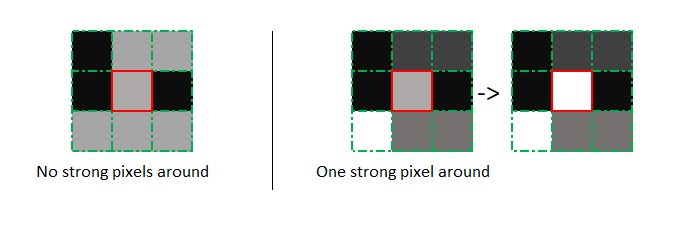



In [6]:

def hysteresis(img, weak, strong=255):
    M, N = img.shape  
    for i in range(1, M-1):
        for j in range(1, N-1):
            if (img[i,j] == weak):
                try:
                    if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                        or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                        or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                        img[i, j] = strong
                    else:
                        img[i, j] = 0
                except IndexError as e:
                    pass
    return img

# Example: 

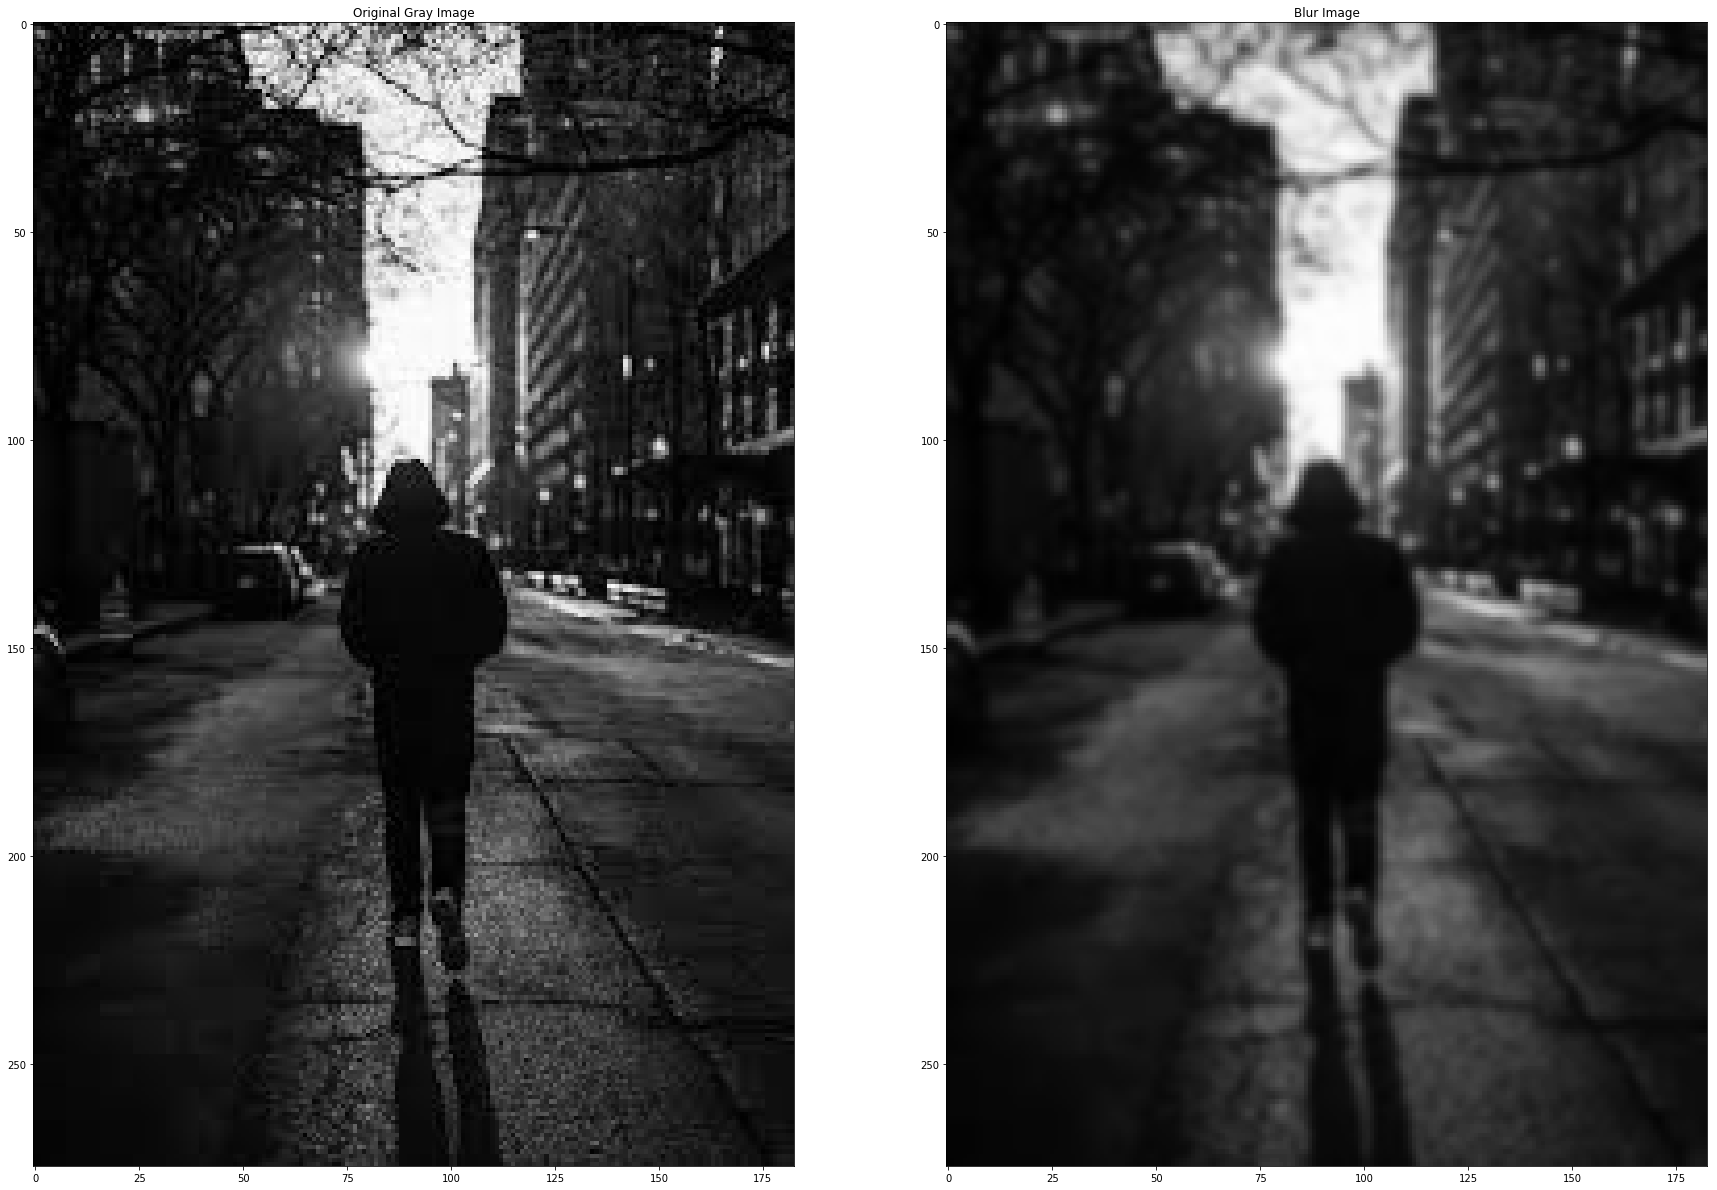

In [7]:
img = mpimg.imread('download (3).jpeg')
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
blur_img = cv2.GaussianBlur(gray,(5,5),0)
fig, (axs1, axs2) = plt.subplots(1,2, figsize=(30,30))
axs1.set_title('Original Gray Image')
axs1.imshow(gray, cmap='gray')
axs2.set_title('Blur Image')
axs2.imshow(blur_img, cmap='gray')
plt.show()

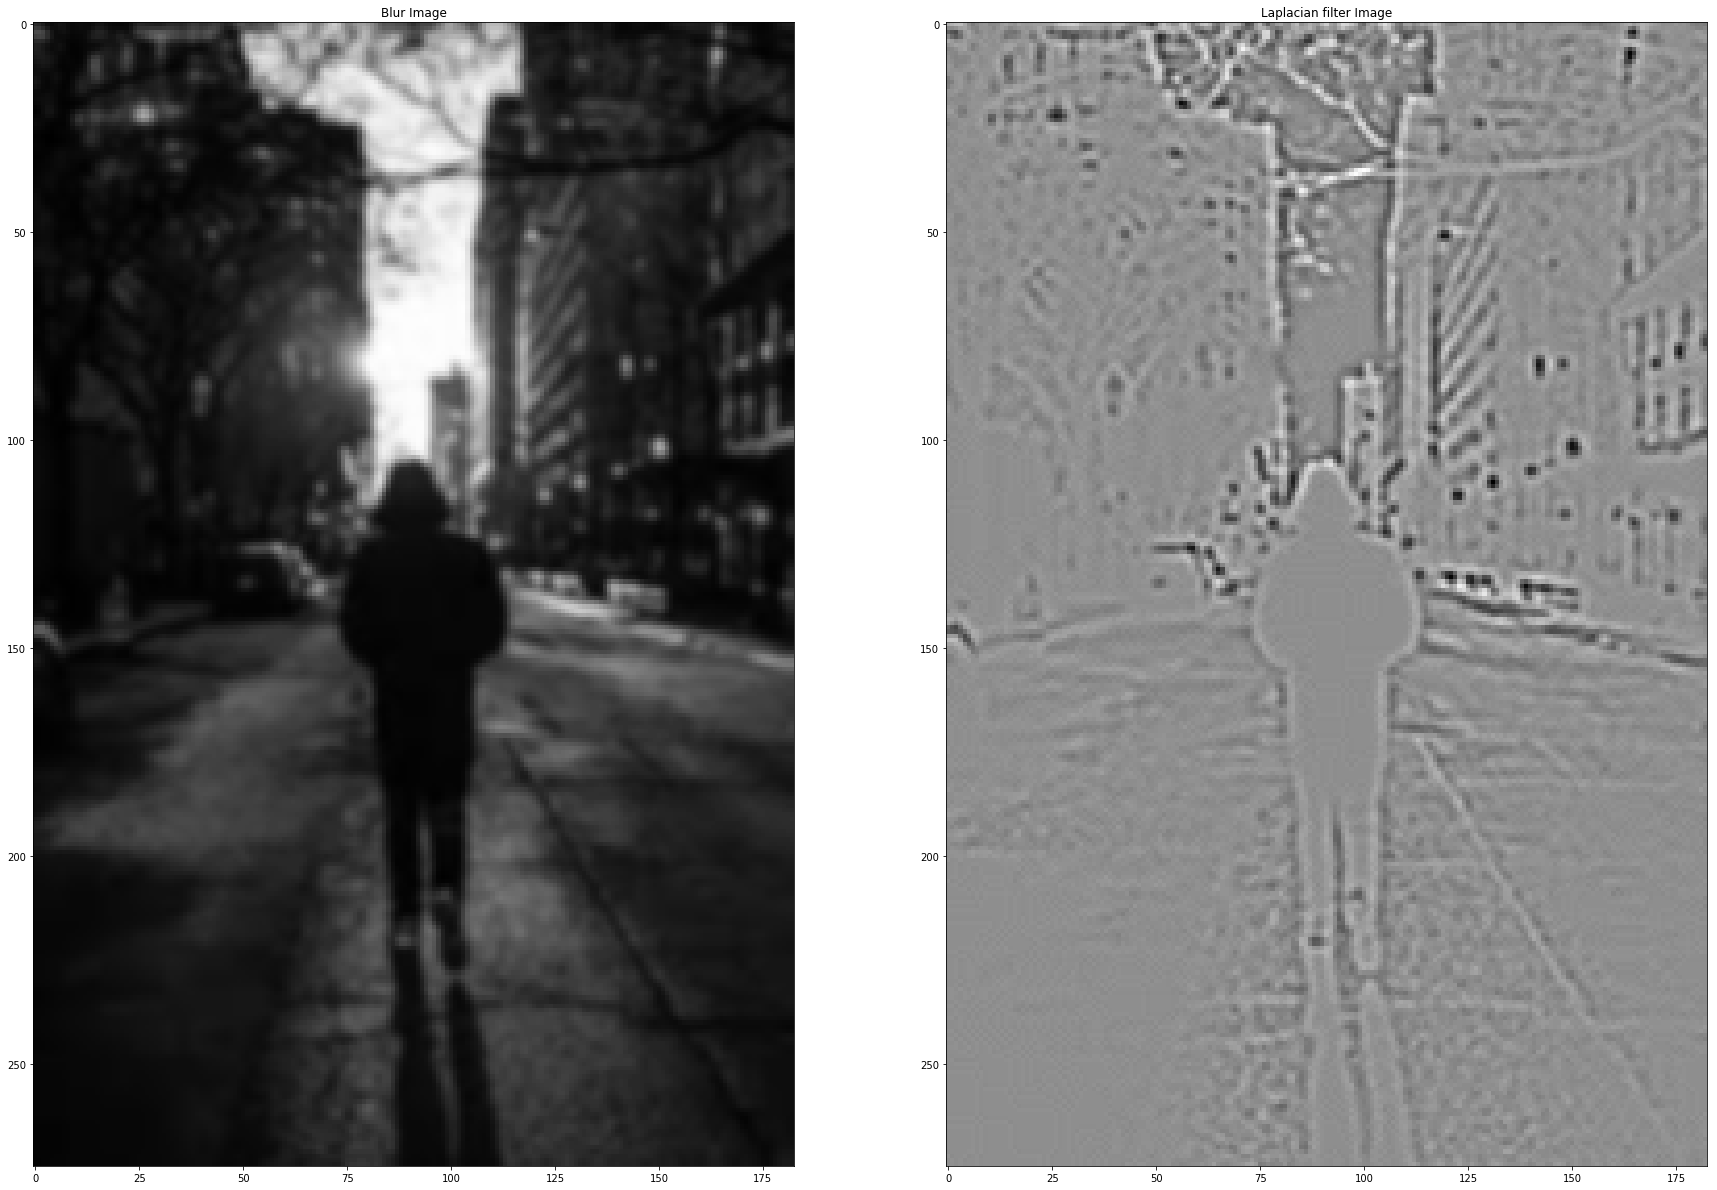

In [8]:
laplacian_img = cv2.Laplacian(blur_img,cv2.CV_64F)
fig, (axs1, axs2) = plt.subplots(1,2, figsize=(30,30))
axs1.set_title('Blur Image')
axs1.imshow(blur_img, cmap='gray')
axs2.set_title('Laplacian filter Image')
axs2.imshow(laplacian_img, cmap='gray')
plt.show()

In [9]:

Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)
Ix = ndimage.filters.convolve(blur_img, Kx)
Iy = ndimage.filters.convolve(blur_img, Ky)
theta = np.arctan2(Iy, Ix)

In [10]:
def non_max_suppression(img, D):
    M, N = img.shape
    Z = np.zeros((M,N), dtype=np.int32)
    angle = D * 180. / np.pi
    angle[angle < 0] += 180

    
    for i in range(1,M-1):
        for j in range(1,N-1):
            try:
                q = 255
                r = 255
                
               #angle 0
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = img[i, j+1]
                    r = img[i, j-1]
                #angle 45
                elif (22.5 <= angle[i,j] < 67.5):
                    q = img[i+1, j-1]
                    r = img[i-1, j+1]
                #angle 90
                elif (67.5 <= angle[i,j] < 112.5):
                    q = img[i+1, j]
                    r = img[i-1, j]
                #angle 135
                elif (112.5 <= angle[i,j] < 157.5):
                    q = img[i-1, j-1]
                    r = img[i+1, j+1]

                if (img[i,j] >= q) and (img[i,j] >= r):
                    Z[i,j] = img[i,j]
                else:
                    Z[i,j] = 0

            except IndexError as e:
                pass
    
    return Z

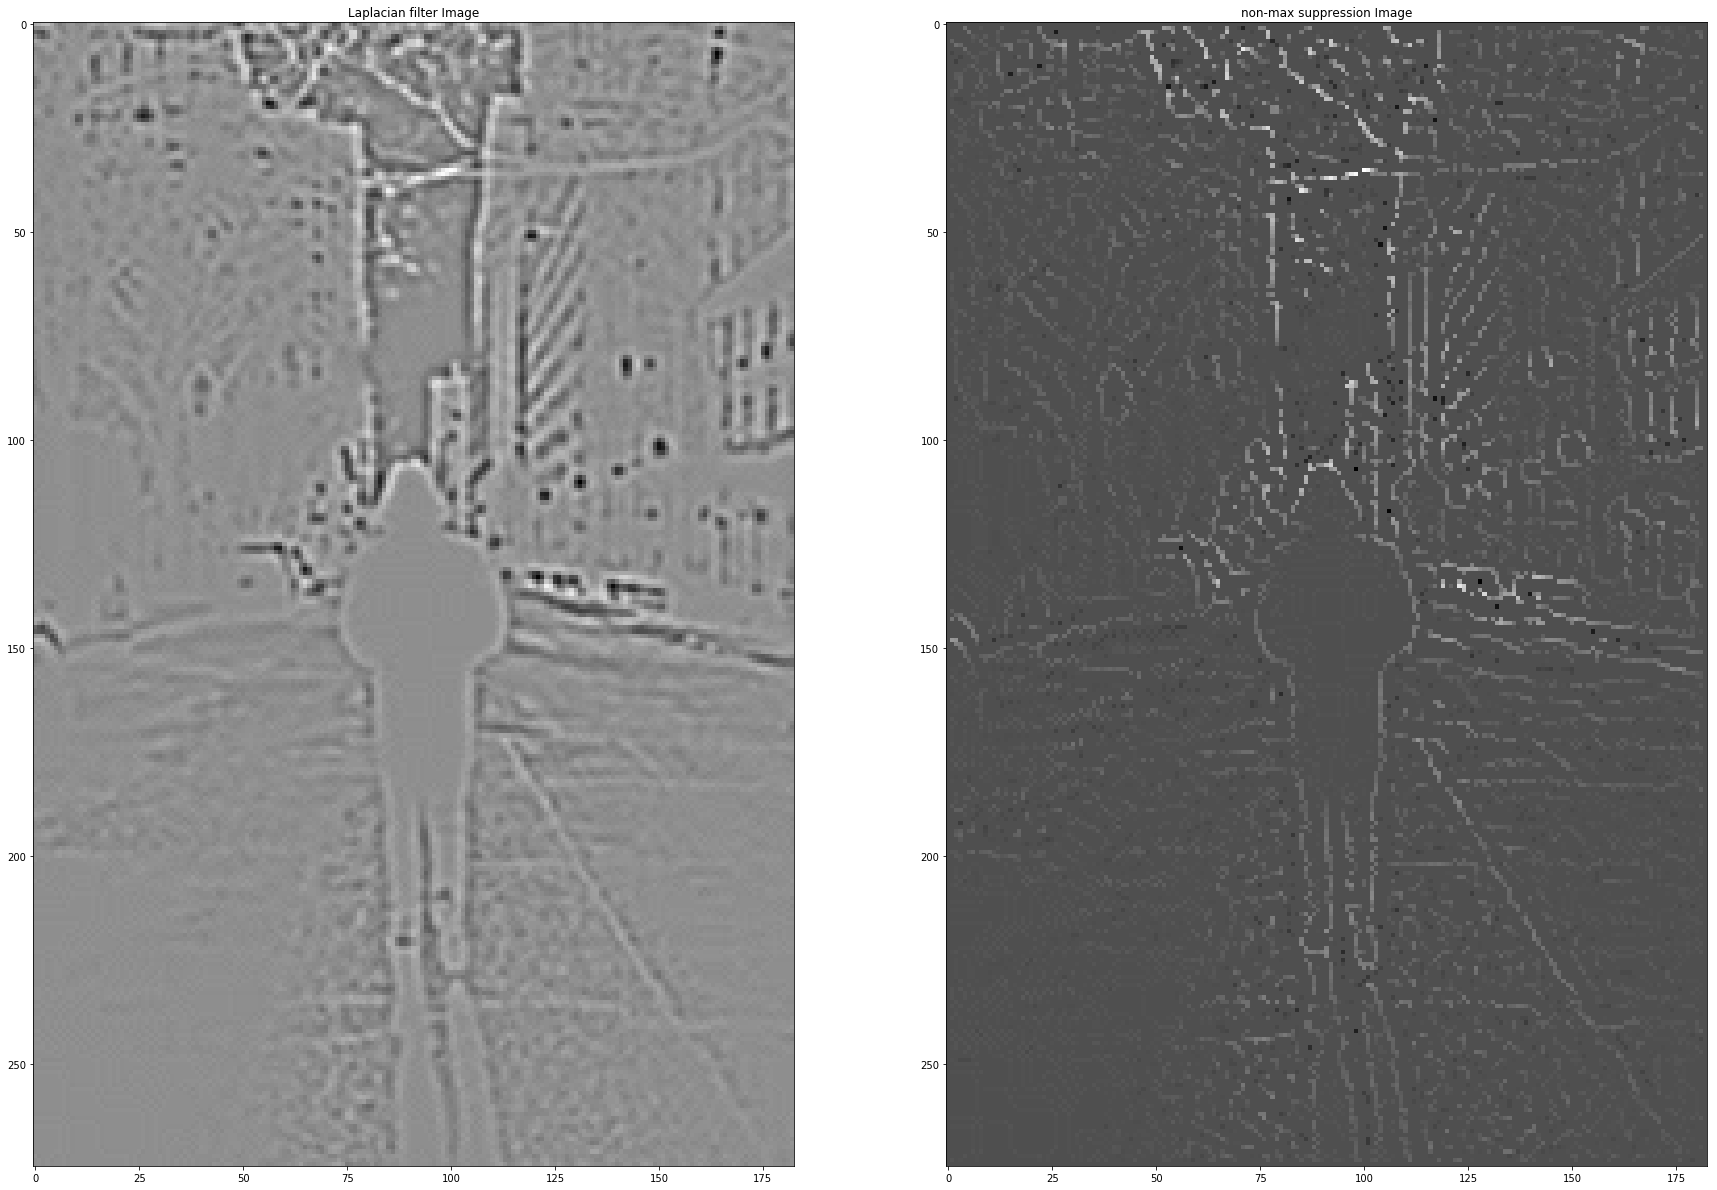

In [11]:
nms_img = non_max_suppression(laplacian_img, theta)
fig, (axs1, axs2) = plt.subplots(1,2, figsize=(30,30))
axs1.set_title('Laplacian filter Image')
axs1.imshow(laplacian_img, cmap='gray')
axs2.set_title('non-max suppression Image')
axs2.imshow(nms_img, cmap='gray')
plt.show()

In [12]:
def threshold(img, lowThresholdRatio=0.05, highThresholdRatio=0.09):
    
    highThreshold = img.max() * highThresholdRatio;
    lowThreshold = highThreshold * lowThresholdRatio;
    
    M, N = img.shape
    res = np.zeros((M,N), dtype=np.int32)
    
    weak = np.int32(25)
    strong = np.int32(255)
    
    strong_i, strong_j = np.where(img >= highThreshold)
    zeros_i, zeros_j = np.where(img < lowThreshold)
    
    weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))
    
    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak
    
    return (res, weak, strong)

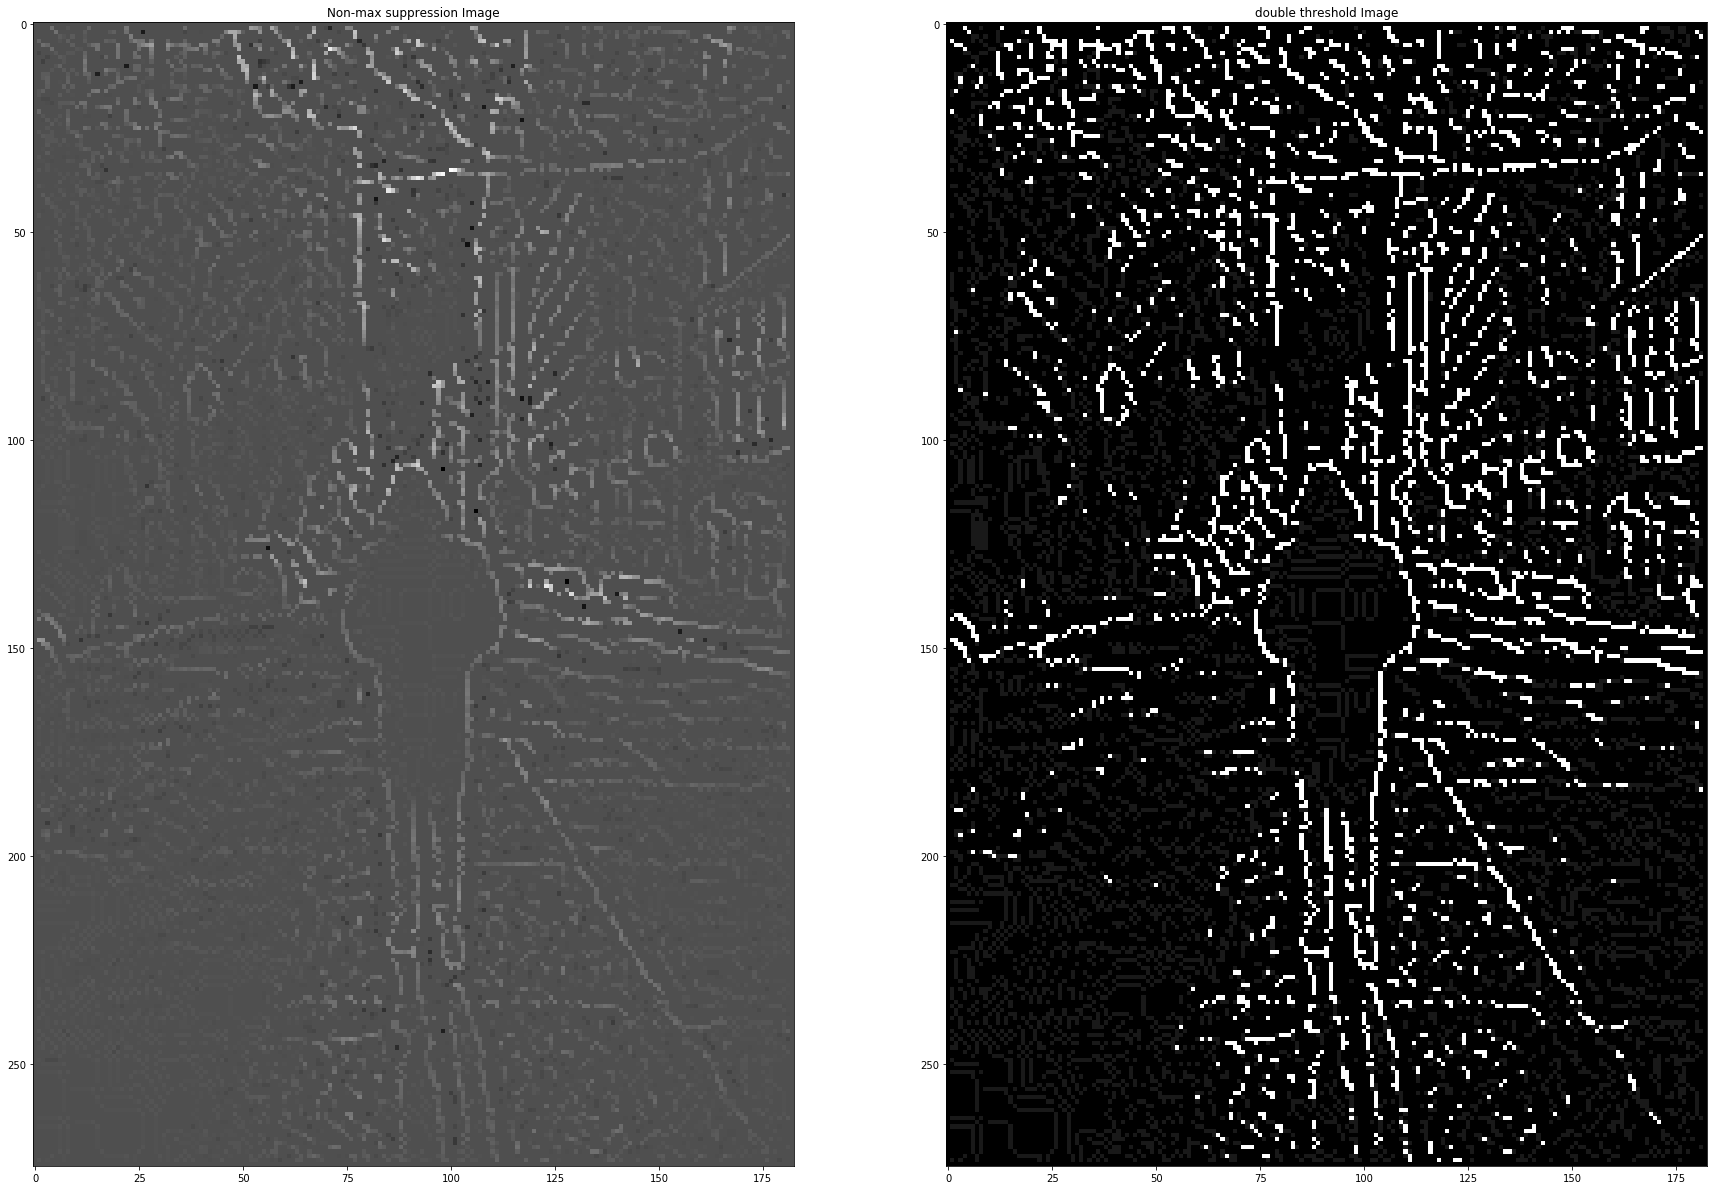

In [13]:
db_threshold_img, w, s = threshold(nms_img) 
fig, (axs1, axs2) = plt.subplots(1,2, figsize=(30,30))
axs1.set_title('Non-max suppression Image')
axs1.imshow(nms_img, cmap='gray')
axs2.set_title('double threshold Image')
axs2.imshow(db_threshold_img, cmap='gray')
plt.show()

In [14]:
def hysteresis(img, weak, strong=255):
    M, N = img.shape  
    for i in range(1, M-1):
        for j in range(1, N-1):
            if (img[i,j] == weak):
                try:
                    if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                        or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                        or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                        img[i, j] = strong
                    else:
                        img[i, j] = 0
                except IndexError as e:
                    pass
    return img

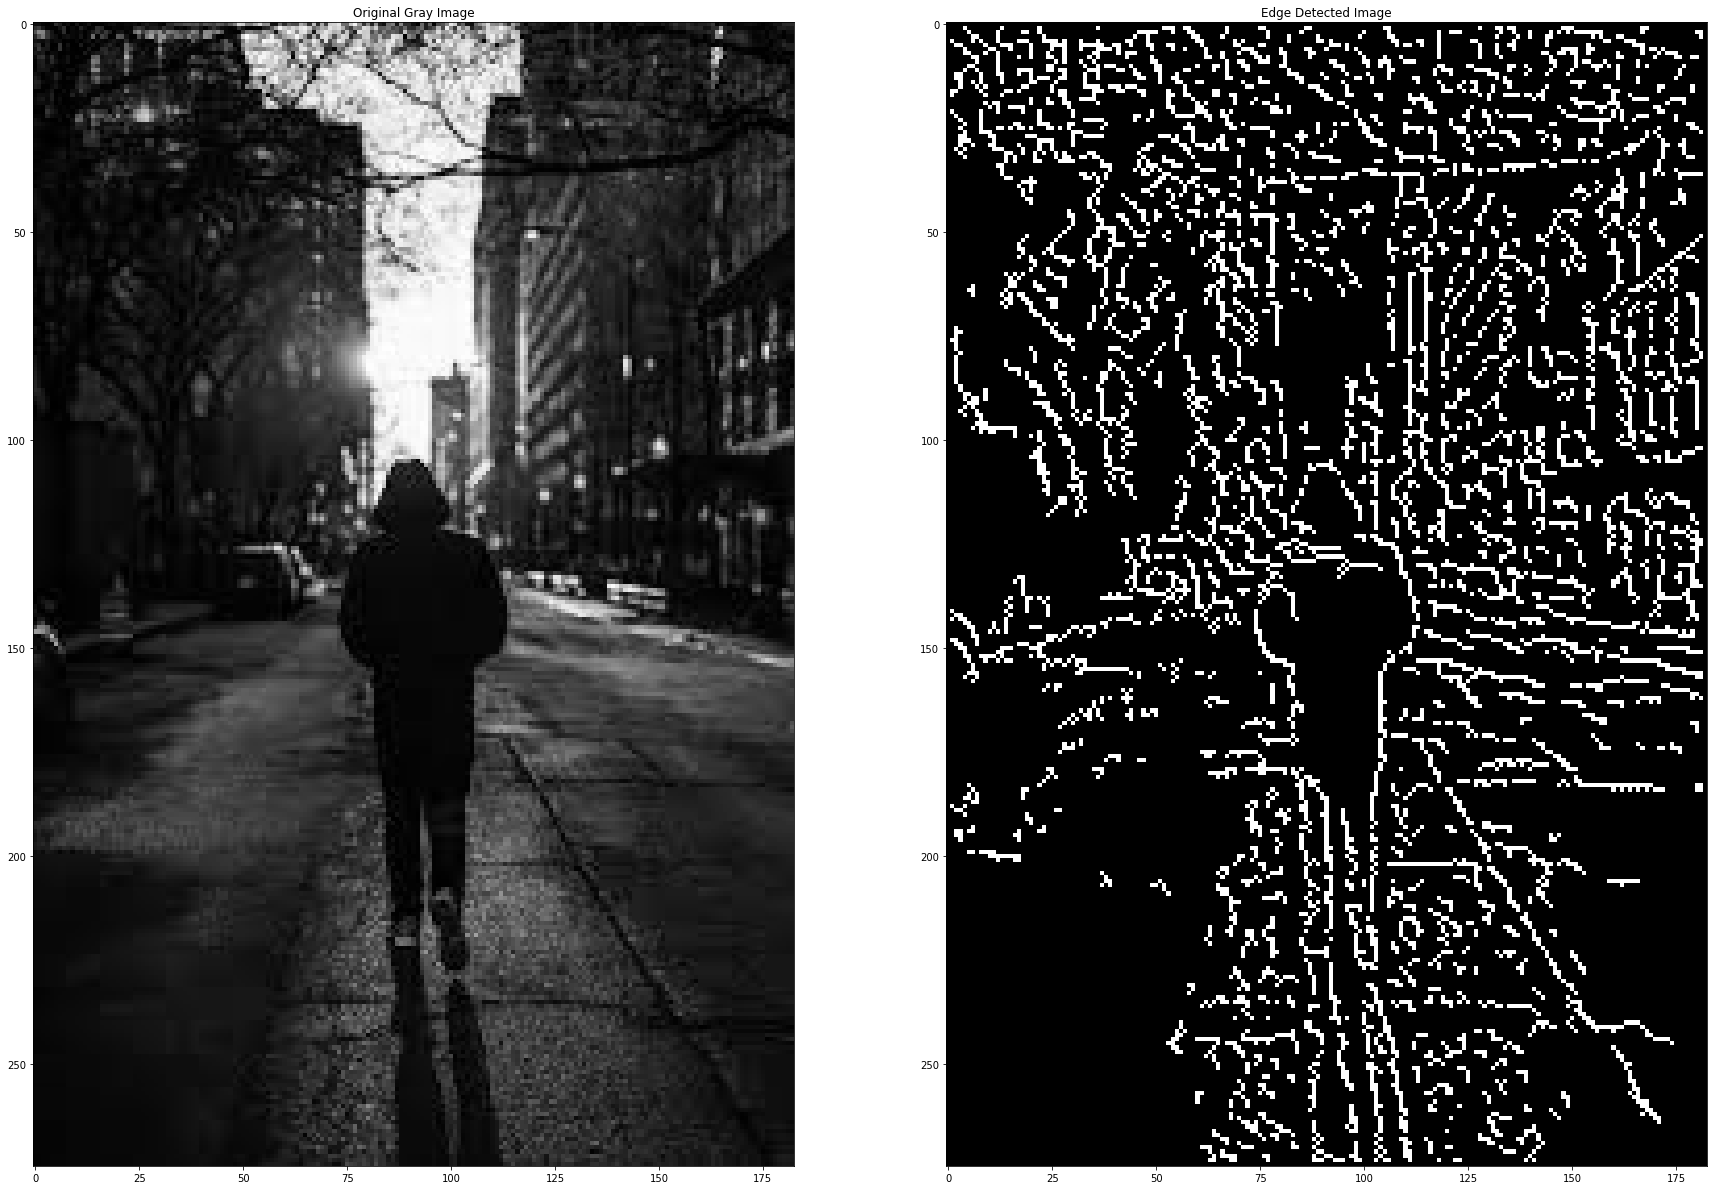

In [19]:
final_img = hysteresis(db_threshold_img, w, s)
fig, (axs1, axs2) = plt.subplots(1,2, figsize=(30,30))
axs1.set_title('Original Gray Image')
axs1.imshow(gray, cmap='gray')
axs2.set_title('Edge Detected Image')
axs2.imshow(final_img, cmap='gray')
plt.show()

# Canny Edge Detection using opencv

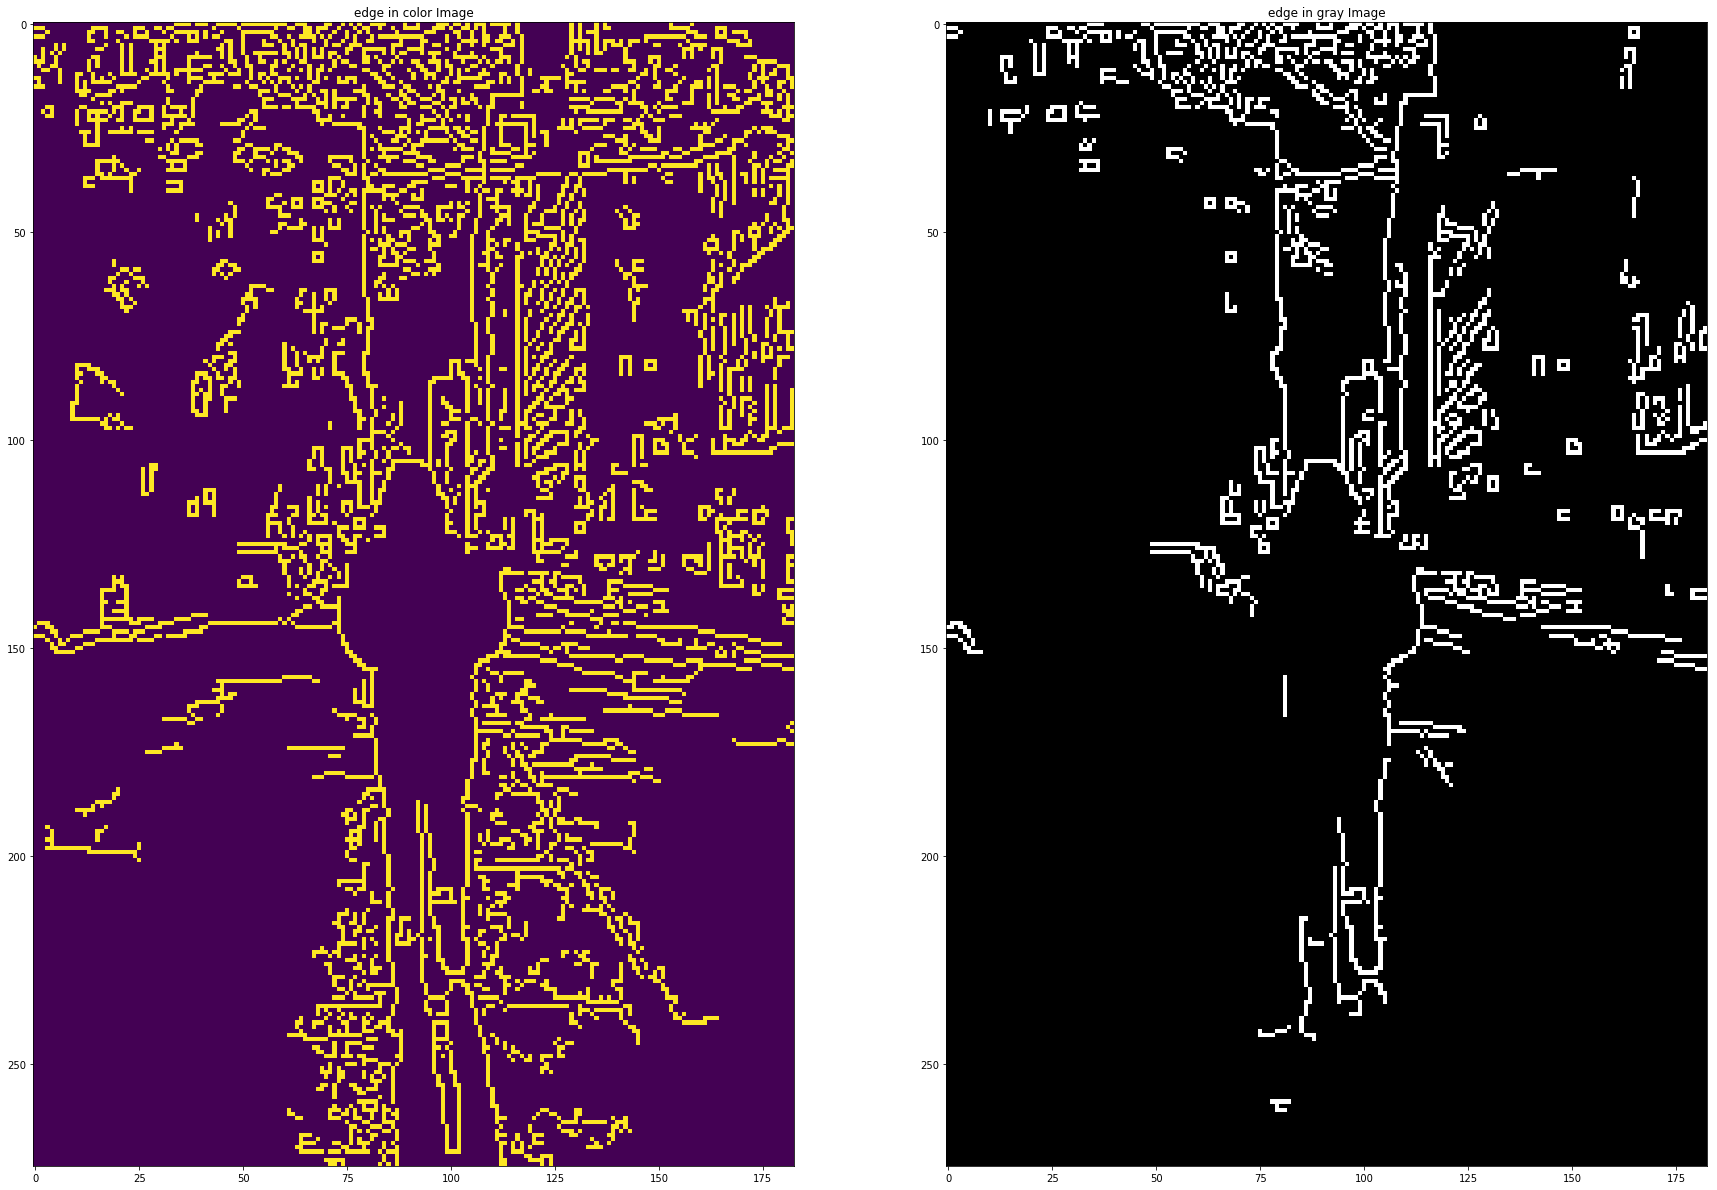

In [20]:
cn_col_img = cv2.Canny(img,100,200)
cn_gray_img = cv2.Canny(gray,200,400)
fig, (axs1, axs2) = plt.subplots(1,2, figsize=(30,30))
axs1.set_title('edge in color Image')
axs1.imshow(cn_col_img)
axs2.set_title('edge in gray Image')
axs2.imshow(cn_gray_img, cmap='gray')
plt.show()